In [ ]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
PROJECT_PATH = '/content'

# CREATE FOLDER TO SAVE MODEL
SAVE_MODEL_PATH = PROJECT_PATH + '/gdrive/MyDrive/Race_Recognition/output' # REPLACE BY YOUR OWN PATH
import os
if not os.path.exists(SAVE_MODEL_PATH):
  os.makedirs(SAVE_MODEL_PATH)



In [ ]:
# Delete old data if you want
# !rm -rf /content/augmented_balanced_skintone_data_pixta.zip

In [ ]:
!pip install gdown==4.6.0
!gdown https://drive.google.com/uc?id=&export=download
!gdown https://drive.google.com/uc?id=&export=download
!gdown https://drive.google.com/uc?id=&export=download

In [ ]:
# Unzip dataset
!unzip -qq augmented_balanced_race_data_pixta_utk.zip
!unzip -qq balanced_race_data_pixta_utk.zip
!unzip -qq race_data_pixta_utk.zip
# !rm Race_data_more_data.zip

In [ ]:
# Prompt:
# I have a "dataset" folder for image classification task that contains subfolders, each subfolder contains images belongs to a class (name of folder is name of the class), write Python code to randomly divide the dataset folder into "Train", "Test" and "Val"

import os
import shutil
import random

def split_dataset(dataset_path, save_path, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    classes = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]

    for cls in classes:
        cls_path = os.path.join(dataset_path, cls)
        images = [img for img in os.listdir(cls_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]

        random.shuffle(images)

        train_size = int(train_ratio * len(images))
        val_size = int(val_ratio * len(images))

        train_images = images[:train_size]
        val_images = images[train_size:train_size + val_size]
        test_images = images[train_size + val_size:]

        for img in train_images:
            target_save_path =  os.path.join(save_path, 'Train', cls)
            if not os.path.exists(target_save_path):
                os.makedirs(target_save_path)
            print(os.path.join(cls_path, img), "->", os.path.join(target_save_path, img))
            shutil.copy(os.path.join(cls_path, img), os.path.join(target_save_path, img))

        for img in val_images:
            target_save_path =  os.path.join(save_path, 'Val', cls)
            if not os.path.exists(target_save_path):
                os.makedirs(target_save_path)
            print(os.path.join(cls_path, img), "->", os.path.join(target_save_path, img))
            shutil.copy(os.path.join(cls_path, img), os.path.join(target_save_path, img))

        for img in test_images:
            target_save_path =  os.path.join(save_path, 'Test', cls)
            if not os.path.exists(target_save_path):
                os.makedirs(target_save_path)
            print(os.path.join(cls_path, img), "->", os.path.join(target_save_path, img))
            shutil.copy(os.path.join(cls_path, img), os.path.join(target_save_path, img))

# ================================Take Train only==========================================
dataset_path = '/content/augmented_balanced_race_data_pixta_utk'  # Replace with your dataset path
save_path = '/content/augmented_balanced_race_data_pixta_utk_samp_1'

split_dataset(dataset_path, save_path, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1)
# ==========================================================================================


# =================================Take Val and Test set====================================
dataset_path = '/content/balanced_race_data_pixta_utk'  # Replace with your dataset path
save_path = '/content/balanced_race_data_pixta_utk_samp_1'

split_dataset(dataset_path, save_path, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1)
# ==========================================================================================




Streaming output truncated to the last 5000 lines.
/content/balanced_race_data_pixta_utk/Mongoloid/4812_58509201.jpg -> /content/balanced_race_data_pixta_utk_samp_1/Train/Mongoloid/4812_58509201.jpg
/content/balanced_race_data_pixta_utk/Mongoloid/2713_4701020.jpg -> /content/balanced_race_data_pixta_utk_samp_1/Train/Mongoloid/2713_4701020.jpg
/content/balanced_race_data_pixta_utk/Mongoloid/4541_56831154.jpg -> /content/balanced_race_data_pixta_utk_samp_1/Train/Mongoloid/4541_56831154.jpg
/content/balanced_race_data_pixta_utk/Mongoloid/1903_3627659.jpg -> /content/balanced_race_data_pixta_utk_samp_1/Train/Mongoloid/1903_3627659.jpg
/content/balanced_race_data_pixta_utk/Mongoloid/10164_78304091.jpg -> /content/balanced_race_data_pixta_utk_samp_1/Train/Mongoloid/10164_78304091.jpg
/content/balanced_race_data_pixta_utk/Mongoloid/4934_62896337.jpg -> /content/balanced_race_data_pixta_utk_samp_1/Train/Mongoloid/4934_62896337.jpg
/content/balanced_race_data_pixta_utk/Mongoloid/1542_2899049.jp


# Define functions



In [ ]:

from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))  # Set the figure size
    for n in range(min(25, len(image_batch))):  # Display 25 images or total images if less than 25
        ax = plt.subplot(5, 5, n+1)  # Create a subplot for each image
        plt.imshow(image_batch[n])  # Display the nth image
        # Convert the label to string for display
        plt.title(str(label_batch[n].numpy()))
        plt.axis('off')  # Turn off the axis
    plt.show()

def extract_labels(dataset):
    all_labels = []
    for images, labels in dataset:
        all_labels.extend(labels.numpy())
    return all_labels

#  incremental approach => use less memmory
def apply_class_weight_conditionally(dataset, condition):
    if not condition:
        return None

    class_counts = {}
    steps = len(dataset)  # Assuming dataset is a tf.data.Dataset object

    for _, labels in dataset.take(steps):
        labels = labels.numpy()
        unique, counts = np.unique(labels, return_counts=True)
        for label, count in zip(unique, counts):
            class_counts[label] = class_counts.get(label, 0) + count

    # Compute class weights
    classes = list(class_counts.keys())
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=classes,
        y=np.concatenate([[class_] * count for class_, count in class_counts.items()])
    )

    return dict(enumerate(class_weights))

In [ ]:

!pip install keras_cv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 606.4/606.4 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 19.2 MB/s eta 0:00:00


# FaceNet

## Prepare loading pretrained model

In [ ]:
!pip install deepface

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 kB 804.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 12.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 10.0 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116934 sha256=e734293aab27cd0bb1c8fbd2f5ba0a1983a73070a320ec9b0fdf620811e80548
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire


In [ ]:
from deepface.basemodels import Facenet
from pathlib import Path
import os
import gdown

from deepface.commons import functions

def loadModel(url = 'https://github.com/serengil/deepface_models/releases/download/v1.0/facenet512_weights.h5'):

    model = Facenet.InceptionResNetV2(dimension = 512)

    #-------------------------

    # home = functions.get_deepface_home()

    if os.path.isfile('/content/facenet512_weights.h5') != True:
        print("facenet512_weights.h5 will be downloaded...")

        # output = home+'/.deepface/weights/facenet512_weights.h5'
        output = '/content/facenet512_weights.h5'
        gdown.download(url, output, quiet=False)

    #-------------------------

    model.load_weights('/content/facenet512_weights.h5')

    #-------------------------

    return model

In [ ]:
# model_test = loadModel()
# model_test.summary()

In [ ]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model

def modify_facenet_for_classification(base_model, num_classes=4):
    # Add global spatial average pooling layer
    x = base_model.output

    # Add a fully-connected layer
    x = Dense(1024, activation='relu')(x)

    # Add a dropout layer for regularization
    x = Dropout(0.5)(x)

    # Add a logistic layer for classification
    predictions = Dense(num_classes, activation='softmax')(x)

    # This is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)

    # For fine-tuning, we want to start with a pre-trained model and update all layers
    for layer in base_model.layers:
        layer.trainable = False

    return model

# # Load the pre-trained Facenet model
# base_model = loadModel()

# # Modify the model for 4-class classification
# model = modify_facenet_for_classification(base_model, num_classes=3)
# model.summary()

## Loading dataset function

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout,
                                     Rescaling, RandomFlip, RandomRotation,
                                     RandomZoom, RandomContrast, RandomBrightness)
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory
import keras_cv
import keras

FILL_VALUE = 114
TRAIN_DATASET_PATH =  '/content/augmented_balanced_race_data_pixta_utk_samp_1/Train'

VAL_DATASET_PATH =    '/content/balanced_race_data_pixta_utk_samp_1/Val'
TEST_DATASET_PATH =   '/content/balanced_race_data_pixta_utk_samp_1/Test'


# Function to load dataset with dynamic image size
def load_dataset(img_height, img_width, batch_size=1, use_augmentation=True):
    print(f"Loading datasets with image size: {img_height}x{img_width} and batch size: {batch_size}")
    train_dataset = image_dataset_from_directory(TRAIN_DATASET_PATH, image_size=(img_height, img_width), batch_size=batch_size)
    val_dataset = image_dataset_from_directory(VAL_DATASET_PATH, image_size=(img_height, img_width), batch_size=batch_size)
    test_dataset = image_dataset_from_directory(TEST_DATASET_PATH, image_size=(img_height, img_width), batch_size=batch_size)

    # ==============SHOW IMAGES===================================
    # Retrieve a single batch of images from the train dataset
    image_batch, label_batch = next(iter(train_dataset))

    # Normalize pixel values to [0,1] as they were rescaled before
    original_images = image_batch.numpy().astype("uint8")

    # Visualize the original batch
    print("Original images:")
    show_batch(original_images, label_batch)
    # ==============================================================

    # Define the data augmentation layer (if needed)
    if use_augmentation:
        print("Start augmentation.......")
        data_augmentation = keras.Sequential([
            preprocessing.RandomFlip("horizontal"),
            preprocessing.RandomRotation(0.1),
            preprocessing.RandomZoom(0.1),
            preprocessing.RandomCrop(img_height, img_width),
            # Photometric transformations
            RandomBrightness(0.2),
            RandomContrast(0.2),
            keras_cv.layers.RandomSaturation(factor=(0.0, 1.0)),  # Adjust saturation randomly within the range
            preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),  # Randomly translate images
            # Add more transformations as needed
        ])

        # Apply the data augmentation to the batch
        augmented_images = data_augmentation(image_batch)
        augmented_images = augmented_images.numpy().astype("uint8")

        # Visualize the augmented batch
        print("Augmented images:")
        show_batch(augmented_images, label_batch)
    else:
        data_augmentation = keras.Sequential([])
        print("Data augmentation is turned off.")

    # Uncommend cache() if you want to train FASTER, but it consumes MORE RAM
    # ======================================================================
    # Cache the data immediately after loading and batching
    # train_dataset = train_dataset.cache()
    # val_dataset = val_dataset.cache()
    # test_dataset = test_dataset.cache()
    # ======================================================================


    # Preprocess the data: normalizing, augmentation, prefetch
    normalization_layer = preprocessing.Rescaling(1./255)
    def preprocess_func(x, y, use_augmentation=False):
      if use_augmentation:
          x = data_augmentation(x)

      x = normalization_layer(x)

      return x, y

    # Apply the preprocessing function and then prefetch
    # Enable augmentation only for the training dataset
    train_dataset = train_dataset.map(lambda x, y: preprocess_func(x, y, use_augmentation)).prefetch(buffer_size=tf.data.AUTOTUNE)

    # NO augmentation for validation and test datasets
    val_dataset = val_dataset.map(preprocess_func).prefetch(buffer_size=tf.data.AUTOTUNE)
    test_dataset = test_dataset.map(preprocess_func).prefetch(buffer_size=tf.data.AUTOTUNE)


    return train_dataset, val_dataset, test_dataset

# load_dataset(50,50,use_augmentation=True, batch_size=16)

## Train model

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv2d_1a_3x3 (Conv2D)      (None, 79, 79, 32)           864       ['input_5[0][0]']             
                                                                                                  
 Conv2d_1a_3x3_BatchNorm (B  (None, 79, 79, 32)           96        ['Conv2d_1a_3x3[0][0]']       
 atchNormalization)                                                                               
                                                                                                  
 Conv2d_1a_3x3_Activation (  (None, 79, 79, 32)           0         ['Conv2d_1a_3x3_BatchNor

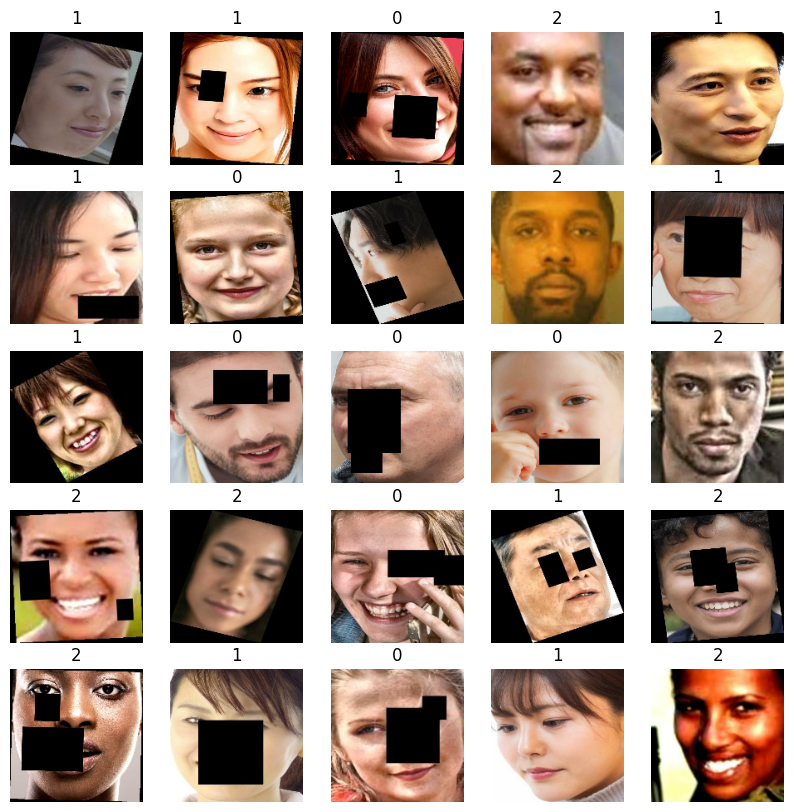

Data augmentation is turned off.
Epoch 1/150
520/520 [==============================] - ETA: 0s - loss: 0.2937 - accuracy: 0.8981
Epoch 1: val_loss improved from inf to 0.16035, saving model to /content/gdrive/MyDrive/Race_Recognition/output/model_race_ptFaceNet_lr0.001_bs64_cw_oversampling_augmented_largerDataset.h5
520/520 [==============================] - 77s 126ms/step - loss: 0.2937 - accuracy: 0.8981 - val_loss: 0.1603 - val_accuracy: 0.9451 - lr: 0.0010
Epoch 2/150
519/520 [============================>.] - ETA: 0s - loss: 0.2326 - accuracy: 0.9141
Epoch 2: val_loss improved from 0.16035 to 0.15294, saving model to /content/gdrive/MyDrive/Race_Recognition/output/model_race_ptFaceNet_lr0.001_bs64_cw_oversampling_augmented_largerDataset.h5
520/520 [==============================] - 64s 122ms/step - loss: 0.2326 - accuracy: 0.9141 - val_loss: 0.1529 - val_accuracy: 0.9480 - lr: 0.0010
Epoch 3/150
519/520 [============================>.] - ETA: 0s - loss: 0.2193 - accuracy: 0.9197


KeyboardInterrupt: 

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import legacy
from keras.optimizers import Adam

batch_size = 64
learning_rate = 0.001
use_augmentation = False

MODEL_NAME = "model_race_ptFaceNet_lr"+str(learning_rate)+"_bs"+str(batch_size)+"_cw_oversampling_augmented_largerDataset.h5"

# Progressive resizing schedule (example: double size after 30 epochs)
sizes = [(160,160)]  # Define your sizes here
epochs_per_size = [150]  # Define how many epochs to train for each size
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
checkpointer = ModelCheckpoint(filepath=SAVE_MODEL_PATH +'/'+ MODEL_NAME,
                               verbose=1,
                               save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.000001, verbose=1)
adam = legacy.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.01)

# Add callbacks for model checkpointing, early stopping, and reducing learning rate
callbacks = [early_stopping, checkpointer, reduce_lr]


for i, (new_height, new_width) in enumerate(sizes):
    base_model  = loadModel()
    model = modify_facenet_for_classification(base_model, num_classes=3)
    model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    # Update dataset with new image size
    train_dataset, val_dataset, test_dataset = load_dataset(new_height, new_width, batch_size, use_augmentation)


    model.fit(train_dataset, validation_data=val_dataset, epochs=epochs_per_size[i],
              callbacks = callbacks)

test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test accuracy: {test_accuracy}, Test loss: {test_loss}")


In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test accuracy: {test_accuracy}, Test loss: {test_loss}")

65/65 [==============================] - 12s 171ms/step - loss: 0.1200 - accuracy: 0.9606
Test accuracy: 0.9605579376220703, Test loss: 0.11996251344680786


##Test the model

130/130 [==============================] - 9s 56ms/step
Average Inference Time per Image: 0.0034 seconds
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95      1386
           1       0.96      0.96      0.96      1386
           2       0.97      0.97      0.97      1386

    accuracy                           0.96      4158
   macro avg       0.96      0.96      0.96      4158
weighted avg       0.96      0.96      0.96      4158

Confusion Matrix:
 [[1318   45   23]
 [  44 1325   17]
 [  23   12 1351]]


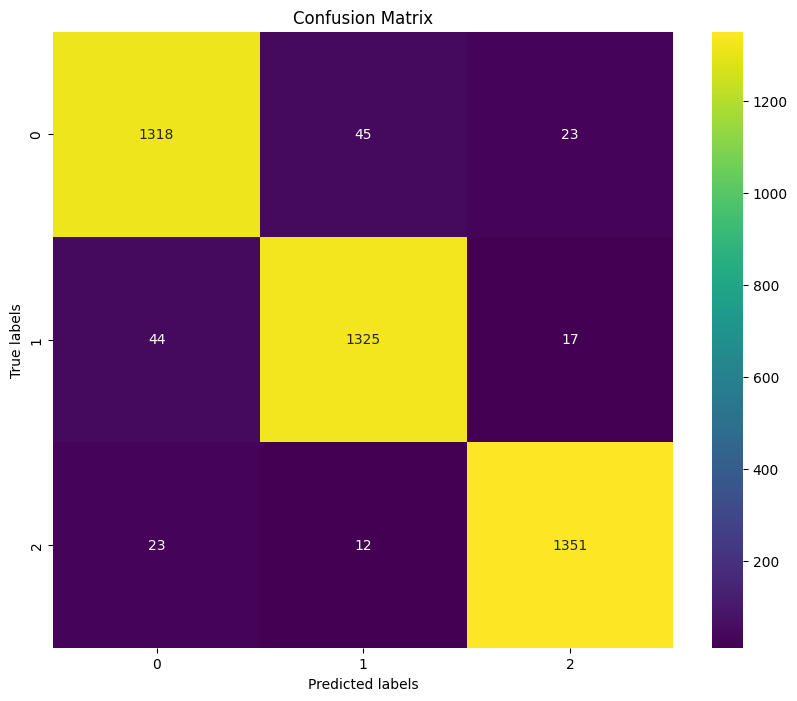

In [ ]:
# MODEL HERE:

import numpy as np
import glob
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import time

import os
import gdown
import tensorflow as tf
from deepface.commons import functions
from deepface.commons.logger import Logger
from keras.layers import Dense, Activation, Flatten, Dropout

# ---------------------------------------

tf_version = int(tf.__version__.split(".", maxsplit=1)[0])

if tf_version == 1:
    from keras.models import Model, Sequential
    from keras.layers import (
        Convolution2D,
        ZeroPadding2D,
        MaxPooling2D,
        Flatten,
        Dropout,
        Activation,
        Lambda,
    )
    from keras import backend as K
else:
    from tensorflow.keras.models import Model, Sequential
    from tensorflow.keras.layers import (
        Convolution2D,
        ZeroPadding2D,
        MaxPooling2D,
        Flatten,
        Dropout,
        Activation,
        Lambda,
    )
    from tensorflow.keras import backend as K

# ---------------------------------------
# =========================LOAD TEST SET=====================================

img_height_test = 160
img_width_test = 160

# Load the test data as before
# _, _, test_dataset = load_dataset(img_height_test, img_width_test, False)


# Unbatch the test dataset
test_images, test_labels = zip(*test_dataset.unbatch())
test_images = np.array(test_images)
test_labels = np.array(test_labels)
# ===========================================================================



# Load the entire model, not just weights
model = load_model('/content/gdrive/MyDrive/Race_Recognition/output/model_race_ptFaceNet_lr0.001_bs64_cw_oversampling_augmented_largerDataset.h5')

# Make predictions for all test images in one batch
start_time = time.time()
predictions = model.predict(test_images)
end_time = time.time()

# Calculate the total inference time
total_inference_time = end_time - start_time
num_images = len(test_images)

# Calculate the average inference time per image
average_inference_time = total_inference_time / num_images
print(f"Average Inference Time per Image: {average_inference_time:.4f} seconds")

# Classification Report
predicted_classes = np.argmax(predictions, axis=1)
report = classification_report(test_labels, predicted_classes)
print("Classification Report:\n", report)

# Confusion Matrix
matrix = confusion_matrix(test_labels, predicted_classes)
print("Confusion Matrix:\n", matrix)

# Visualize the Confusion Matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(matrix, annot=True, fmt="g", cmap='viridis')  # 'g' for integer format
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
